In [1]:
import os
os.chdir('/Users/emilycanavan/Desktop/symposium')

In [2]:
import pandas as pd

In [3]:
data = pd.read_excel('pandas_simple.xlsx')

In [4]:
del data['county_code'] #not neccessary

In [5]:
data = data.drop(data[data['denial_reason_1'] == 1111].index)
data = data.drop(data[data['denial_reason_1'] == 7].index)
data = data.drop(data[data['interest_rate'] == 'Exempt'].index)
data = data.drop(data[data['debt_to_income_ratio'] == 'Exempt'].index)
data = data.drop(data[data['combined_loan_to_value_ratio'] == 'Exempt'].index)
data = data.drop(data[data['applicant_age'] == '8888'].index)
#exclude exempt entries, denial reason 7 for incomplete app, and reason codes 1111 & 8888 (which mean NA)

In [6]:
data = data.drop(data[data['action_taken'] == 2].index)
data = data.drop(data[data['action_taken'] == 4].index)
data = data.drop(data[data['action_taken'] == 5].index)
data = data.drop(data[data['action_taken'] == 8].index)
data = data.drop(data[data['action_taken'] == 6].index)
#only including loan originated (1) and application denied (3) entries

In [7]:
data = data[data['state_code'].notna()]
data = data[data['income'].notna()] #delete nulls

In [8]:
data = data[data['applicant_ethnicity_1'].notna()]
data = data[data['debt_to_income_ratio'].notna()]
data = data[data['combined_loan_to_value_ratio'].notna()]
data = data[data['property_value'].notna()] #delete nulls

In [9]:
data.shape #total entries

(246802, 19)

In [10]:
max(data['income']) #highest income

51776.0

In [11]:
q_low = data['income'].quantile(0.01)
q_hi  = data['income'].quantile(0.99)
data = data[(data['income'] < q_hi) & (data['income'] > q_low)] 
#exclude outliers in new dataset

In [12]:
max(data['income']) #new highest income

607.0

In [13]:
min(data['income']) #lowest income

25.0

In [14]:
#creating categorical columns for demographic data
e_dict = {1:'Hispanic or Latino',2:'Not Hispanic or Latino',
                       3:'Not Provided',4:'Not Provided'} 
data['ethnicity_categorical'] = data['applicant_ethnicity_1'].map(e_dict)
s_dict = {1:'Male',2:'Female',3:'Not Provided',4:'Not Applicable',6:'Both Selections Made'}
data['sex_categorical'] = data['applicant_sex'].map(s_dict)
r_dict = {1:'Native American or Alaska Native',2:'Asian',3:'Asian Indian',
                   22:'Chinese',23:'Filipino',24:'Japanese',25:'Korean',
                  26:'Vietnamese',27:'Other Asian',3:'Black or African American',
                  4:'Native Hawaiian or Other Pacific Islander',41:'Native Hawaiian',
                  42:'Guamanian or Chamorro',43:'Samoan',44:'Other Pacific Islander',
                  5:'White',6:'Not Provided'}
data['race_categorical'] = data['applicant_race_1'].map(r_dict)

In [15]:
#creating categorical columns for other variables
action_dictionary = {1:'Approved',3:'Denied'}
data['action_categorical'] = data['action_taken'].map(action_dictionary)
purpose_dictionary = {1:'Home Purchase',2:'Home Improvement',31:'Refinancing',
                      32:'Cash-Out Refinancing',4:'Other',5:'Not Applicable'}
data['purpose_categorical'] = data['loan_purpose'].map(purpose_dictionary)
type_dictionary = {1:'Conventional',2:'FHA Insured',3:'VA Guaranteed',
                   4:'USDA RHA or FSA Guaranteed'}
data['type_categorical'] = data['loan_type'].map(type_dictionary)
occupancy_dictionary = {1:'Principal Residence',2:'Second Residence',3:'Investment Property'}
data['occupancy_categorical'] = data['occupancy_type'].map(occupancy_dictionary)
denial_dictionary = {1:'Debt to Income Ratio',2:'Employment History',
                     3:'Credit History',4:'Collateral',5:'Insufficent Cash',
                    6:'Unverifiable Information',
                    8:'Mortgage Insurance Denied',9:'Other',10:'Not Applicable'}
data['denial_categorical'] = data['denial_reason_1'].map(denial_dictionary)

In [16]:
#we see that Debt to Income ratio has a large impact on approval status
data['combined_loan_to_value_ratio'] = data['combined_loan_to_value_ratio'].astype('float64')
import numpy as np
data['combined_loan_to_value_ratio'] = np.ceil(data['combined_loan_to_value_ratio']).astype(int) #change to int

In [17]:
data['income'] = data['income'].astype(int) #change to int

In [18]:
approval_data = data[data['denial_reason_1'] == 10] #splitting approvals

In [19]:
#new column where 1 = favorable DtoI ratio and 0 = unfavorable DtoI ratio on the basis of favorable = <=43%
def map_debt_to_income(value):
    if value in ['30%-<36%', '40', '37', '20%-<30%', '36', '38', '39', '<20%', '42', '41', '43']:
        return 1
    elif value in ['>60%', '45', '48', '44', '47', '50%-60%', '49', '46']:
        return 0
    else:
        return None 

In [20]:
data['DI_indicator'] = data['debt_to_income_ratio'].apply(map_debt_to_income)

In [21]:
data['property_value'] = data['property_value'].astype(int)

In [22]:
del(data['loan_purpose'],data['occupancy_type'],data['loan_type'])
del(data['state_code'],data['applicant_ethnicity_1'],data['applicant_ethnicity_observed'])
del(data['applicant_race_1'],data['applicant_race_observed'],data['interest_rate'])
del(data['applicant_sex'],data['applicant_sex_observed'],data['denial_reason_1'])

In [23]:
cat_cols = ['ethnicity_categorical','sex_categorical','race_categorical','action_categorical','purpose_categorical',
           'type_categorical','occupancy_categorical','denial_categorical','applicant_age','debt_to_income_ratio']

In [24]:
#1=loan originated 0=denied application
data['action_taken'].unique()
def map_action_binary(value):
    if value in [1]:
        return 1
    else:
        return 0
data['action_taken'] = data['action_taken'].apply(map_action_binary)

In [25]:
df = pd.get_dummies(data,columns=cat_cols,drop_first=True)

In [26]:
from sklearn.model_selection import train_test_split

In [27]:
feature_cols = ['income', 'combined_loan_to_value_ratio', 'DI_indicator','loan_amount','property_value',
               'debt_to_income_ratio_30%-<36%',
 'debt_to_income_ratio_36',
 'debt_to_income_ratio_37',
 'debt_to_income_ratio_38',
 'debt_to_income_ratio_39',
 'debt_to_income_ratio_40',
 'debt_to_income_ratio_41',
 'debt_to_income_ratio_42',
 'debt_to_income_ratio_43',
 'debt_to_income_ratio_44',
 'debt_to_income_ratio_45',
 'debt_to_income_ratio_46',
 'debt_to_income_ratio_47',
 'debt_to_income_ratio_48',
 'debt_to_income_ratio_49',
 'debt_to_income_ratio_50%-60%',
 'debt_to_income_ratio_<20%',
 'debt_to_income_ratio_>60%']
X = df[feature_cols]
y = df.action_taken

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.45)

In [29]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(max_depth = 9)

In [30]:
clf = clf.fit(X_train,y_train)

In [31]:
y_pred = clf.predict(X_test)

In [32]:
from sklearn.metrics import accuracy_score
print("Accuracy:",accuracy_score(y_test, y_pred))

Accuracy: 0.9117146771361058


In [33]:
from sklearn.metrics import classification_report,confusion_matrix

In [34]:
predictions = clf.predict(X_test)

In [35]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.82      0.30      0.44     12560
           1       0.92      0.99      0.95     96201

    accuracy                           0.91    108761
   macro avg       0.87      0.65      0.70    108761
weighted avg       0.90      0.91      0.89    108761



In [36]:
print(confusion_matrix(y_test,predictions))

[[ 3816  8744]
 [  858 95343]]


In [39]:
from sklearn.tree import export_text
from sklearn import tree
text_representation = tree.export_text(clf,feature_names=feature_cols)
print(text_representation)

|--- debt_to_income_ratio_>60% <= 0.50
|   |--- combined_loan_to_value_ratio <= 100.50
|   |   |--- debt_to_income_ratio_50%-60% <= 0.50
|   |   |   |--- combined_loan_to_value_ratio <= 80.50
|   |   |   |   |--- loan_amount <= 660000.00
|   |   |   |   |   |--- property_value <= 160000.00
|   |   |   |   |   |   |--- combined_loan_to_value_ratio <= 20.50
|   |   |   |   |   |   |   |--- income <= 44.50
|   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |--- income >  44.50
|   |   |   |   |   |   |   |   |--- combined_loan_to_value_ratio <= 13.50
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |--- combined_loan_to_value_ratio >  13.50
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- combined_loan_to_value_ratio >  20.50
|   |   |   |   |   |   |   |--- debt_to_income_ratio_48 <= 0.50
|   |   |   |   |   |   |   |   |--- income <= 100.50
|   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   

In [40]:
class_name = clf.classes_

In [41]:
feautre_name=X_col_names = list(X_train.columns)
feature_names = X_col_names

In [42]:
val = np.array(class_name).astype('str').tolist() 

In [43]:
import graphviz

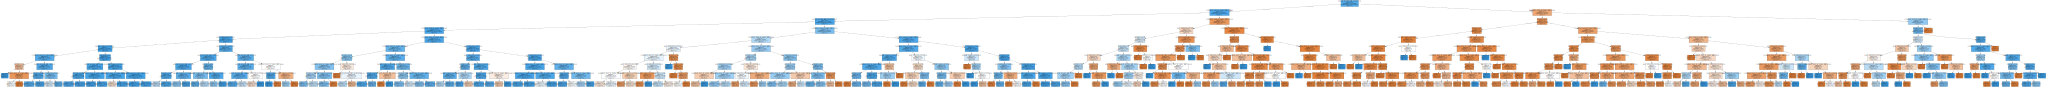

In [44]:
dot_data = tree.export_graphviz(clf, out_file=None, max_depth=9,
                                feature_names=feature_names,  
                                class_names=val,
                                filled=True)

# Draw graph
graph = graphviz.Source(dot_data, format="png")
graph

In [45]:
my_tree = graphviz.Source(dot_data, directory ='/Users/emilycanavan/Desktop/symposium') 
my_tree.save(filename='tree.jpg', directory='/Users/emilycanavan/Desktop/symposium')
my_tree.render(filename='tree',directory='/Users/emilycanavan/Desktop/symposium',view = True, format='jpg')

'/Users/emilycanavan/Desktop/symposium/tree.jpg'